# Laboratorio 4
### Clasificación de Imágenes con CNN (CIFAR-10)

---- 

Nancy Mazariegos 22513


Santiago Pereira 22318




----

### Parte 1 - Preparación del Conjunto de Datos

Este bloque carga el dataset CIFAR-10, normaliza las imágenes a valores entre 0 y 1, separa un conjunto de validación y define las clases. Finalmente, muestra algunas imágenes de ejemplo con sus etiquetas donde verifica que los datos se fueron cargados correctamente.


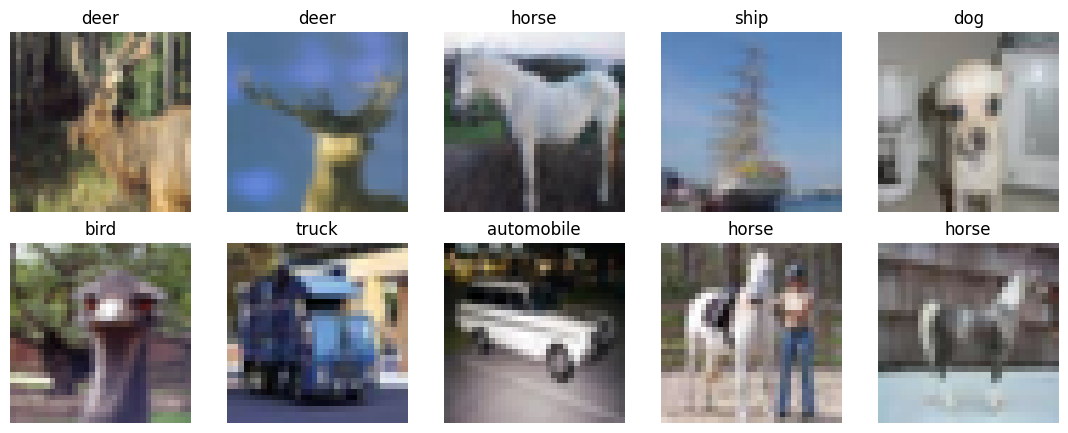

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

val_ratio = 0.1
num_val = int(len(x_train) * val_ratio)
x_val, y_val = x_train[:num_val], y_train[:num_val]
x_train, y_train = x_train[num_val:], y_train[num_val:]

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def show_samples(images, labels, rows=2, cols=5, class_names=class_names, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(images), size=rows*cols, replace=False)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx])
        plt.title(class_names[int(labels[idx][0])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_train, y_train, rows=2, cols=5)


---

### Parte 2 - Modelo Base ANN

Este bloque construye y entrena un modelo ANN totalmente conectado como referencia: aplana las imágenes, pasa por capas densas con ReLU y Dropout. Usa Adam y EarlyStopping, mide el tiempo de entrenamiento y reporta la exactitud y pérdida en el conjunto de prueba.


In [16]:
import time
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras import layers, models, callbacks

tf.random.set_seed(42)

ann = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Flatten(),                             
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

start = time.time()
hist_ann = ann.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early],
    verbose=1
)
train_time_s = time.time() - start

print(f"Tiempo de entrenamiento ANN: {train_time_s:.1f} s")

test_loss, test_acc = ann.evaluate(x_test, y_test, verbose=0)
print(f"ANN - Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.2041 - loss: 2.1912 - val_accuracy: 0.3372 - val_loss: 1.8440
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2752 - loss: 1.9480 - val_accuracy: 0.3434 - val_loss: 1.8217
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2924 - loss: 1.9159 - val_accuracy: 0.3588 - val_loss: 1.7913
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3055 - loss: 1.8846 - val_accuracy: 0.3720 - val_loss: 1.7777
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.3135 - loss: 1.8648 - val_accuracy: 0.3858 - val_loss: 1.7539
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.3230 - loss: 1.8435 - val_accuracy: 0.3916 - val_loss: 1.7458
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.3243 - loss: 1.8452 - val_accuracy: 0.3886 - val_loss: 1.7481
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3338 - loss: 1.8256 - 

Este bloque define una función para graficar las curvas de entrenamiento y validación de un modelo, permitiendo visualizar su desempeño y detectar posibles problemas de sobreajuste.


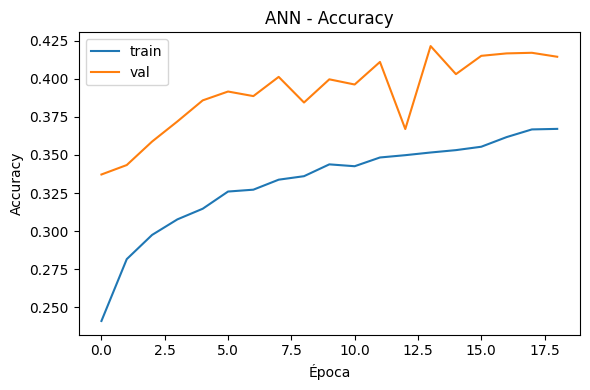

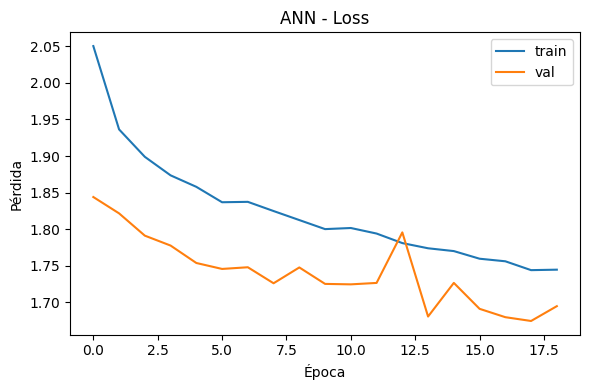

In [17]:
import matplotlib.pyplot as plt

def plot_history(h, title_prefix="ANN"):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} - Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title(f"{title_prefix} - Loss")
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(hist_ann, "ANN")


----

### Parte 3 - Implementación de CNN 


Este bloque construye y entrena una CNN con varias capas convolucionales y de pooling para extraer características de las imágenes. Incluye Dropout para evitar sobreajuste y usa EarlyStopping y ReduceLROnPlateau para optimizar el entrenamiento. Al final, mide el tiempo de ejecución y reporta la exactitud y pérdida en el conjunto de prueba.


In [18]:
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras import layers, models, callbacks
import time

tf.random.set_seed(42)

cnn = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

cnn.summary()

early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

start = time.time()
hist_cnn = cnn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)
train_time_cnn = time.time() - start
print(f"Tiempo de entrenamiento CNN: {train_time_cnn:.1f} s")

test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, y_test, verbose=0)
print(f"CNN - Test Accuracy: {test_acc_cnn:.4f} | Test Loss: {test_loss_cnn:.4f}")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,986 (1.54 MB)

 Trainable params: 402,986 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.2593 - loss: 1.9637 - val_accuracy: 0.4936 - val_loss: 1.4058 - learning_rate: 0.0010
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.4895 - loss: 1.4136 - val_accuracy: 0.6018 - val_loss: 1.1237 - learning_rate: 0.0010
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.5707 - loss: 1.2140 - val_accuracy: 0.6596 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.6172 - loss: 1.0930 - val_accuracy: 0.6902 - val_loss: 0.8836 - learning_rate: 0.0010
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.6530 - loss: 0.9925 - val_accuracy: 0.7078 - val_loss: 0.8195 - learning_rate: 0.0010
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.6770 - loss: 0.9303 - val_accuracy: 0.7290 - val_loss: 0.7803 - learning_rate: 0.0010
Epoch 7/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.6983 - l

Este bloque reutiliza la función plot_history para mostrar las curvas de accuracy y pérdida del modelo CNN, comparando el desempeño en entrenamiento y validación a lo largo de las épocas.


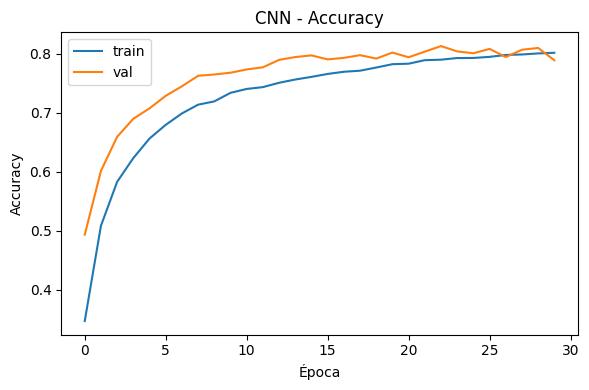

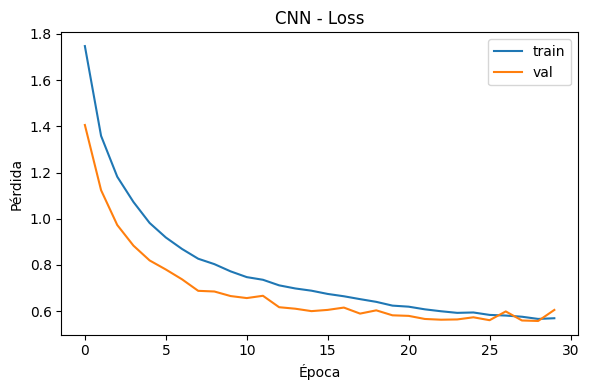

In [19]:
plot_history(hist_cnn, "CNN")

----

### Parte 4 - Evaluación y Comparación

Este bloque define una función que compara gráficamente el rendimiento de la ANN y la CNN: muestra lado a lado las curvas de accuracy y ppérdida en entrenamiento y validación, lo que permite visualizar claramente cuál modelo aprende mejor y generaliza más.


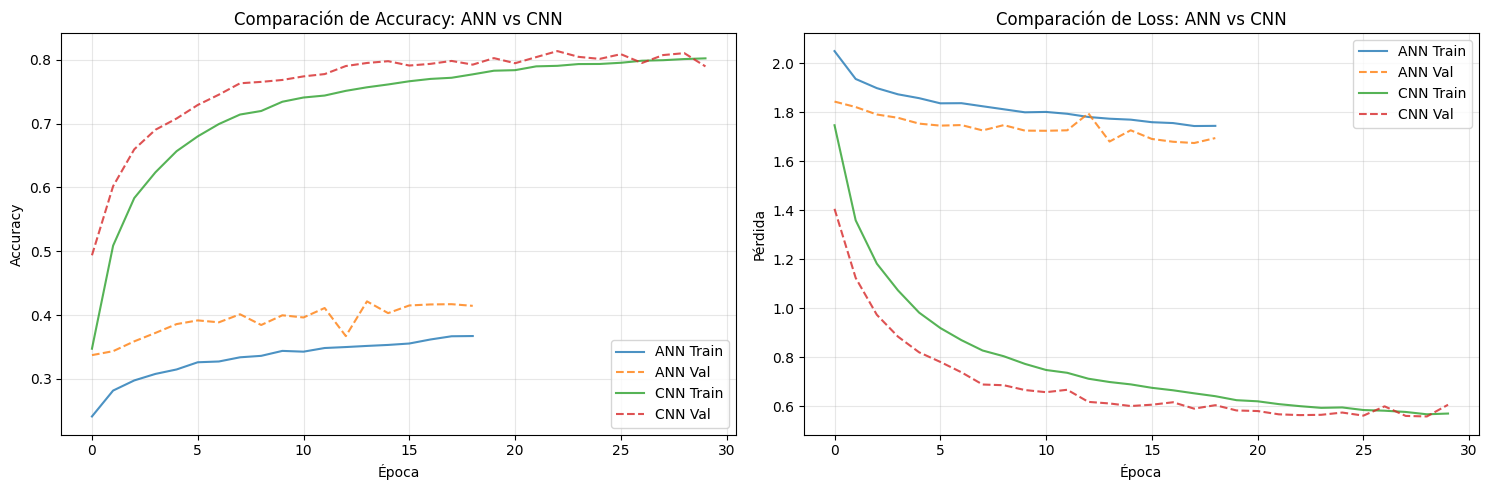

In [20]:
def plot_comparison(hist_ann, hist_cnn):    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist_ann.history["accuracy"], label="ANN Train", linestyle='-', alpha=0.8)
    plt.plot(hist_ann.history["val_accuracy"], label="ANN Val", linestyle='--', alpha=0.8)
    plt.plot(hist_cnn.history["accuracy"], label="CNN Train", linestyle='-', alpha=0.8)
    plt.plot(hist_cnn.history["val_accuracy"], label="CNN Val", linestyle='--', alpha=0.8)
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.title("Comparación de Accuracy: ANN vs CNN")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(hist_ann.history["loss"], label="ANN Train", linestyle='-', alpha=0.8)
    plt.plot(hist_ann.history["val_loss"], label="ANN Val", linestyle='--', alpha=0.8)
    plt.plot(hist_cnn.history["loss"], label="CNN Train", linestyle='-', alpha=0.8)
    plt.plot(hist_cnn.history["val_loss"], label="CNN Val", linestyle='--', alpha=0.8)
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Comparación de Loss: ANN vs CNN")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_comparison(hist_ann, hist_cnn)

Este bloque imprime un resumen de los resultados en el conjunto de prueba: muestra la accuracy, la loss y el tiempo de entrenamiento de la ANN y de la CNN, y calcula el porcentaje de mejora de la CNN respecto a la ANN.


In [21]:
print("RESUMEN DE RESULTADOS EN CONJUNTO DE PRUEBA")
print(f"ANN  - Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f} | Tiempo: {train_time_s:.1f}s")
print(f"CNN  - Accuracy: {test_acc_cnn:.4f} | Loss: {test_loss_cnn:.4f} | Tiempo: {train_time_cnn:.1f}s")

improvement = ((test_acc_cnn - test_acc) / test_acc) * 100
print(f"Mejora de CNN sobre ANN: {improvement:.1f}%")

RESUMEN DE RESULTADOS EN CONJUNTO DE PRUEBA
ANN  - Accuracy: 0.4218 | Loss: 1.6725 | Tiempo: 301.7s
CNN  - Accuracy: 0.7972 | Loss: 0.6048 | Tiempo: 1189.0s
Mejora de CNN sobre ANN: 89.0%


Este bloque genera las predicciones de prueba para la ANN y la CNN, convierte esas predicciones a clases y aplana las etiquetas reales para poder compararlas con las clases predichas.


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_ann = ann.predict(x_test, verbose=0)
y_pred_cnn = cnn.predict(x_test, verbose=0)

y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_flat = y_test.flatten()

Este bloque define una función para crear y mostrar la matriz de confusión con etiquetas de las clases, luego la aplica para comparar los resultados de la ANN y la CNN en el conjunto de prueba.


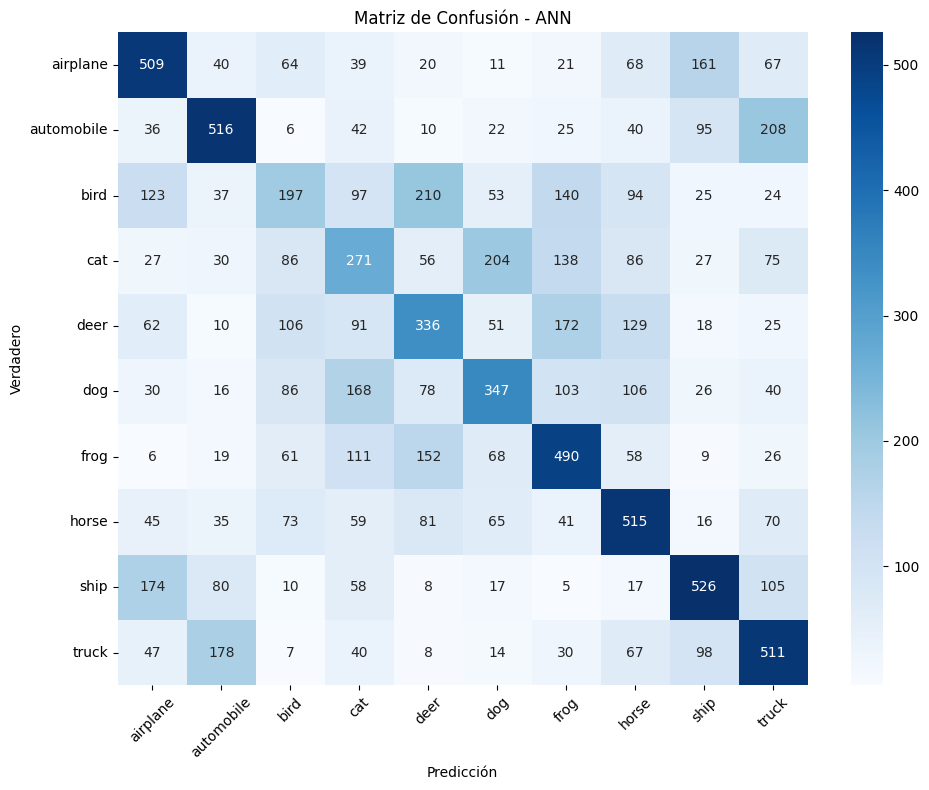

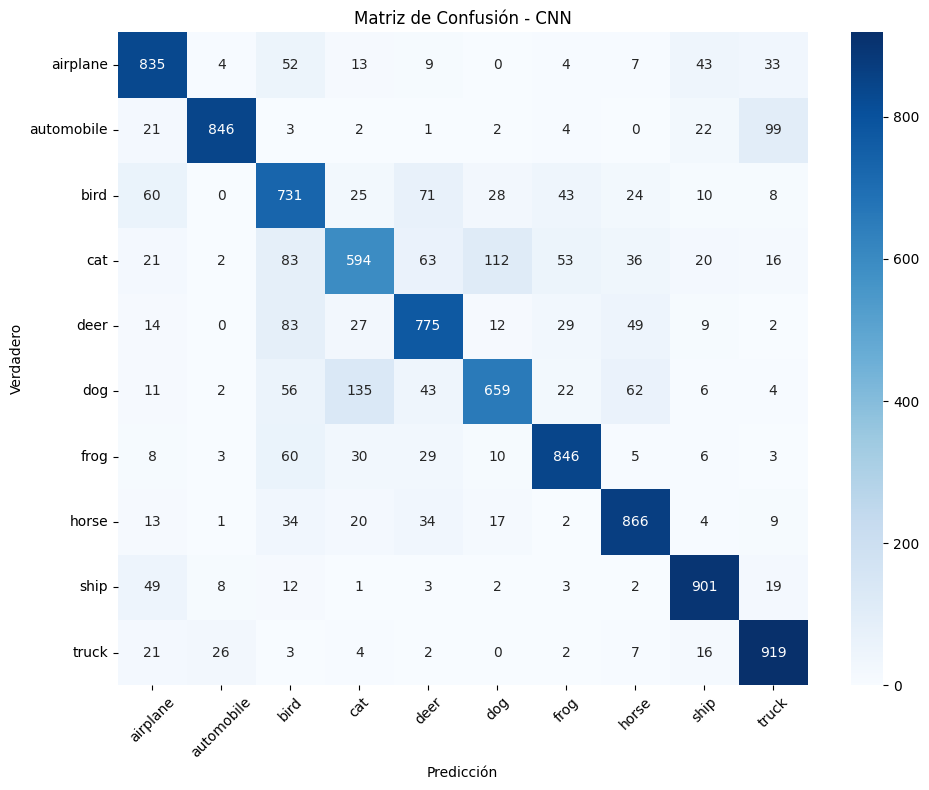

In [23]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {title}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

cm_ann = plot_confusion_matrix(y_test_flat, y_pred_ann_classes, class_names, "ANN")
cm_cnn = plot_confusion_matrix(y_test_flat, y_pred_cnn_classes, class_names, "CNN")

Este bloque imprime el reporte de clasificación para la ANN y para la CNN, mostrando métricas como precisión, recall y f1-score de cada clase en el conjunto de prueba.


In [24]:
print("REPORTE DE CLASIFICACIÓN - ANN")
print(classification_report(y_test_flat, y_pred_ann_classes, target_names=class_names))

print("\nREPORTE DE CLASIFICACIÓN - CNN")
print(classification_report(y_test_flat, y_pred_cnn_classes, target_names=class_names))

REPORTE DE CLASIFICACIÓN - ANN
              precision    recall  f1-score   support

    airplane       0.48      0.51      0.49      1000
  automobile       0.54      0.52      0.53      1000
        bird       0.28      0.20      0.23      1000
         cat       0.28      0.27      0.27      1000
        deer       0.35      0.34      0.34      1000
         dog       0.41      0.35      0.37      1000
        frog       0.42      0.49      0.45      1000
       horse       0.44      0.52      0.47      1000
        ship       0.53      0.53      0.53      1000
       truck       0.44      0.51      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.42      0.42      0.42     10000


REPORTE DE CLASIFICACIÓN - CNN
              precision    recall  f1-score   support

    airplane       0.79      0.83      0.81      1000
  automobile       0.95      0.85      0.89      1000
        bird   

Este bloque define una función que selecciona ejemplos donde el modelo se equivocó, muestra las imágenes con su clase real y la predicha, y luego despliega predicciones erróneas tanto de la ANN como de la CNN para analizarlas visualmente.


EJEMPLOS DE PREDICCIONES ERRÓNEAS


C:\Users\jmper\AppData\Local\Temp\ipykernel_15552\3014795692.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_class = class_names[int(true_labels[idx])]


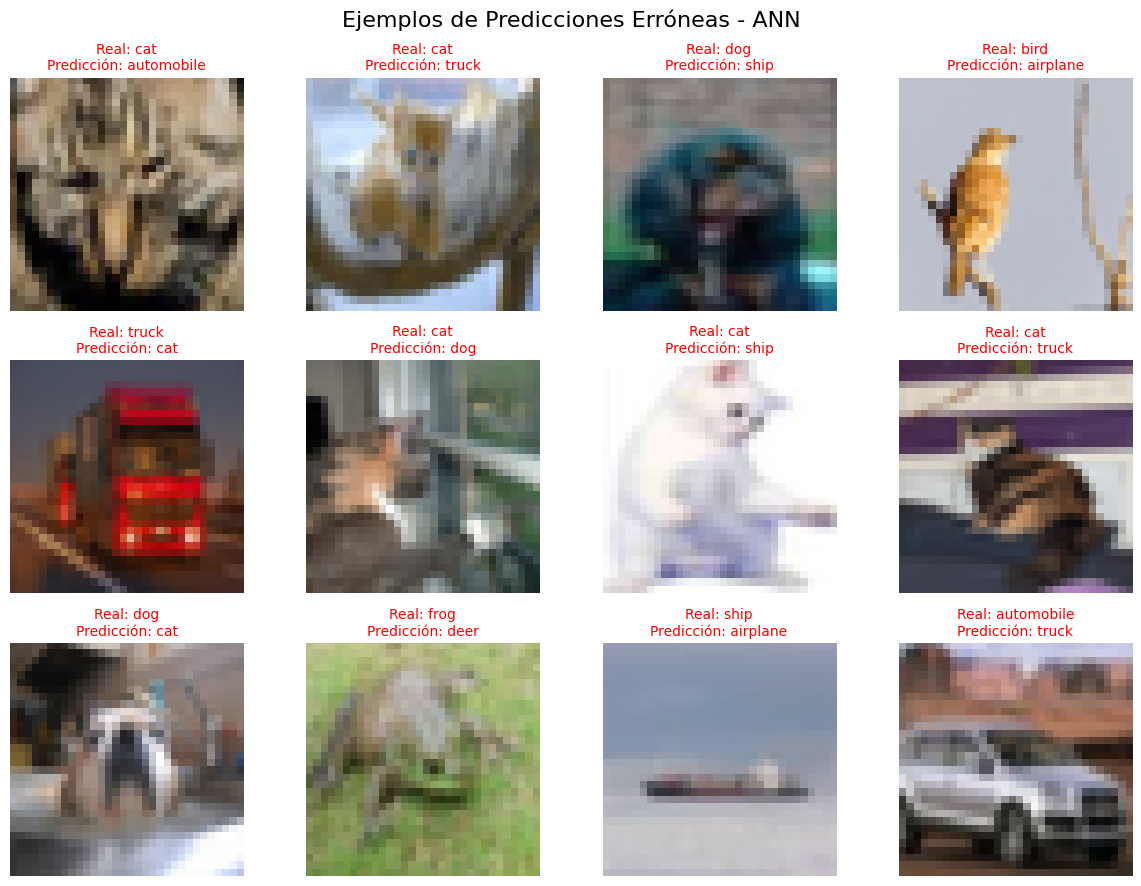

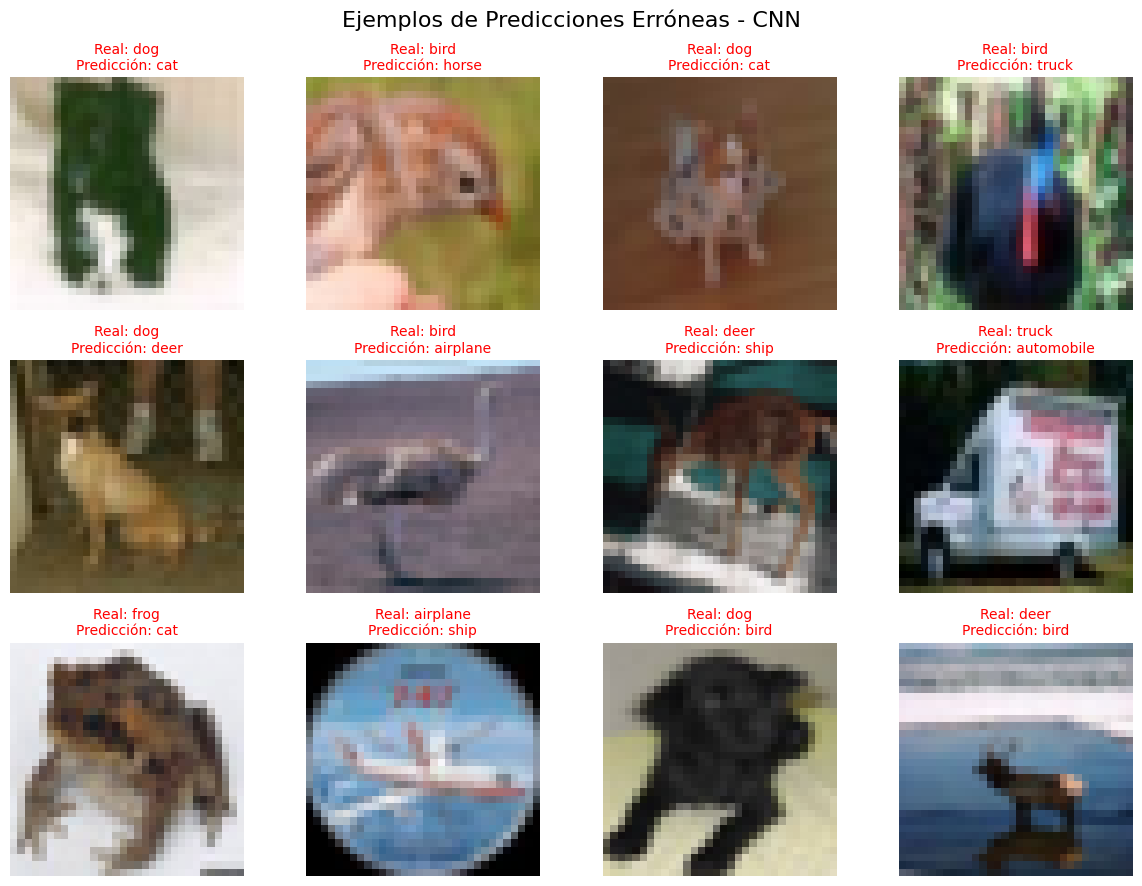

In [25]:
def show_wrong_predictions(images, true_labels, pred_labels, class_names, model_name, num_examples=12):
    wrong_indices = np.where(true_labels.flatten() != pred_labels)[0]
    
    np.random.seed(42)
    selected_indices = np.random.choice(wrong_indices, min(num_examples, len(wrong_indices)), replace=False)
    
    rows = 3
    cols = 4
    plt.figure(figsize=(cols*3, rows*3))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx])
        
        true_class = class_names[int(true_labels[idx])]
        pred_class = class_names[int(pred_labels[idx])]
        
        plt.title(f'Real: {true_class}\nPredicción: {pred_class}', 
                 color='red', fontsize=10)
        plt.axis('off')
    
    plt.suptitle(f'Ejemplos de Predicciones Erróneas - {model_name}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

print("EJEMPLOS DE PREDICCIONES ERRÓNEAS")

show_wrong_predictions(x_test, y_test, y_pred_ann_classes, class_names, "ANN")
show_wrong_predictions(x_test, y_test, y_pred_cnn_classes, class_names, "CNN")

Este bloque calcula y compara las métricas de precisión, recall y F1-score de cada clase entre la ANN y la CNN. Genera un DataFrame con los valores de ambas redes y además muestra la diferencia de desempeño (CNN – ANN) para ver en qué clases mejora más la CNN.


In [ ]:
def analyze_per_class_performance(y_true, y_pred_ann, y_pred_cnn, class_names):    
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_ann, recall_ann, f1_ann, _ = precision_recall_fscore_support(
        y_true, y_pred_ann, average=None, zero_division=0)
    precision_cnn, recall_cnn, f1_cnn, _ = precision_recall_fscore_support(
        y_true, y_pred_cnn, average=None, zero_division=0)
    
    import pandas as pd
    
    comparison_df = pd.DataFrame({
        'Clase': class_names,
        'ANN_Precision': precision_ann,
        'CNN_Precision': precision_cnn,
        'ANN_Recall': recall_ann,
        'CNN_Recall': recall_cnn,
        'ANN_F1': f1_ann,
        'CNN_F1': f1_cnn
    })
    
    comparison_df['Precision_Diff'] = comparison_df['CNN_Precision'] - comparison_df['ANN_Precision']
    comparison_df['Recall_Diff'] = comparison_df['CNN_Recall'] - comparison_df['ANN_Recall']
    comparison_df['F1_Diff'] = comparison_df['CNN_F1'] - comparison_df['ANN_F1']
    
    return comparison_df

comparison_results = analyze_per_class_performance(y_test_flat, y_pred_ann_classes, y_pred_cnn_classes, class_names)

print("ANÁLISIS DE RENDIMIENTO POR CLASE")
print(comparison_results.round(4))

ANÁLISIS DE RENDIMIENTO POR CLASE
        Clase  ANN_Precision  ...  Recall_Diff  F1_Diff
0    airplane         0.4806  ...        0.326   0.3190
1  automobile         0.5369  ...        0.330   0.3680
2        bird         0.2830  ...        0.534   0.4583
3         cat         0.2777  ...        0.323   0.3675
4        deer         0.3504  ...        0.439   0.4205
5         dog         0.4073  ...        0.312   0.3408
6        frog         0.4206  ...        0.356   0.3900
7       horse         0.4364  ...        0.351   0.3691
8        ship         0.5255  ...        0.375   0.3589
9       truck         0.4440  ...        0.408   0.3951

[10 rows x 10 columns]


Este bloque crea gráficas de barras para comparar a la ANN y la CNN en cada clase, mostrando lado a lado la precisión, el recall y el F1-score. Esto permite visualizar claramente en qué clases la CNN tiene mejor rendimiento que la ANN.


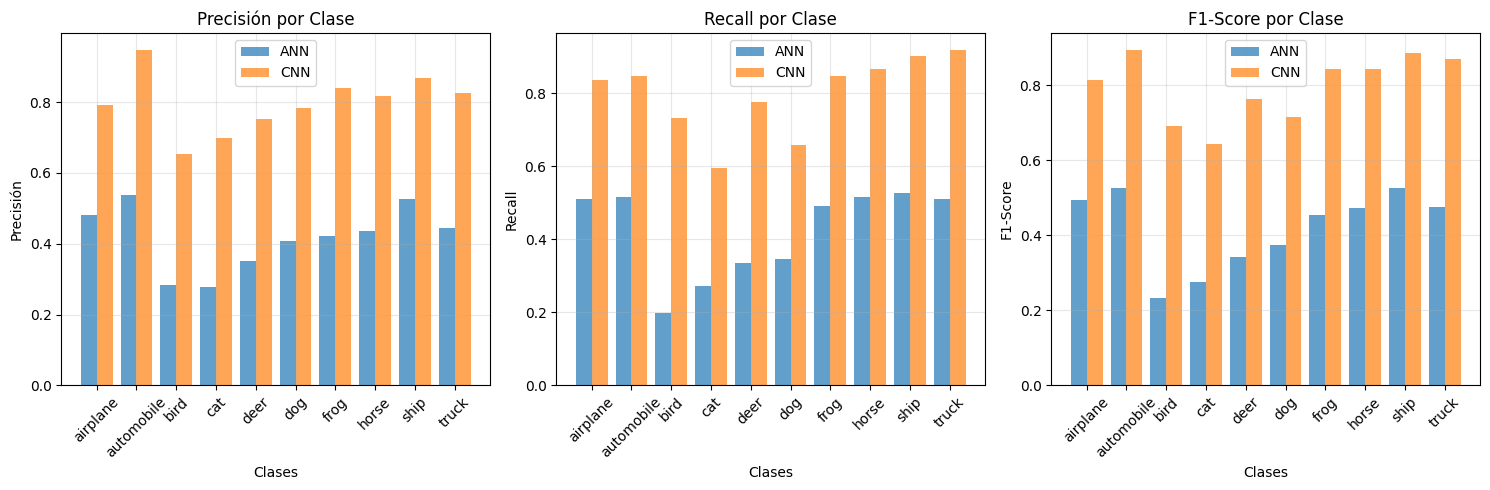

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
x_pos = np.arange(len(class_names))
plt.bar(x_pos - 0.2, comparison_results['ANN_Precision'], 0.4, label='ANN', alpha=0.7)
plt.bar(x_pos + 0.2, comparison_results['CNN_Precision'], 0.4, label='CNN', alpha=0.7)
plt.xlabel('Clases')
plt.ylabel('Precisión')
plt.title('Precisión por Clase')
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.bar(x_pos - 0.2, comparison_results['ANN_Recall'], 0.4, label='ANN', alpha=0.7)
plt.bar(x_pos + 0.2, comparison_results['CNN_Recall'], 0.4, label='CNN', alpha=0.7)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase')
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(x_pos - 0.2, comparison_results['ANN_F1'], 0.4, label='ANN', alpha=0.7)
plt.bar(x_pos + 0.2, comparison_results['CNN_F1'], 0.4, label='CNN', alpha=0.7)
plt.xlabel('Clases')
plt.ylabel('F1-Score')
plt.title('F1-Score por Clase')
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Este bloque imprime las conclusiones del experimento. Resume el rendimiento general de la ANN y la CNN con su accuracy, tiempo y mejora; muestra en qué clases la CNN obtiene mayor ganancia de F1-Score y en cuáles le cuesta más; y finalmente calcula una métrica de eficiencia, comparando la mejora obtenida en relación con el tiempo extra de entrenamiento que necesita la CNN frente a la ANN.


In [28]:
print("CONCLUSIONES")

print(f"1. RENDIMIENTO GENERAL:")
print(f"   ANN: {test_acc:.1%} accuracy en {train_time_s:.0f}s")
print(f"   CNN: {test_acc_cnn:.1%} accuracy en {train_time_cnn:.0f}s")
print(f"   Mejora: {improvement:.1f}%")

best_classes_cnn = comparison_results.nlargest(3, 'F1_Diff')['Clase'].tolist()
worst_classes_cnn = comparison_results.nsmallest(3, 'F1_Diff')['Clase'].tolist()

print(f"\n2. CLASES DONDE CNN MEJORA MÁS:")
for i, clase in enumerate(best_classes_cnn, 1):
    mejora = comparison_results[comparison_results['Clase'] == clase]['F1_Diff'].iloc[0]
    print(f"   {i}. {clase}: +{mejora:.3f} F1-Score")

print(f"\n3. CLASES MÁS DESAFIANTES PARA CNN:")
for i, clase in enumerate(worst_classes_cnn, 1):
    diff = comparison_results[comparison_results['Clase'] == clase]['F1_Diff'].iloc[0]
    print(f"   {i}. {clase}: {diff:+.3f} F1-Score")

efficiency = (test_acc_cnn - test_acc) / (train_time_cnn - train_time_s)
print(f"\n4. EFICIENCIA:")
print(f"   Mejora de accuracy por segundo adicional: {efficiency:.4f}")
print(f"   CNN toma {train_time_cnn/train_time_s:.1f}x más tiempo que ANN")



CONCLUSIONES
1. RENDIMIENTO GENERAL:
   ANN: 42.2% accuracy en 302s
   CNN: 79.7% accuracy en 1189s
   Mejora: 89.0%

2. CLASES DONDE CNN MEJORA MÁS:
   1. bird: +0.458 F1-Score
   2. deer: +0.421 F1-Score
   3. truck: +0.395 F1-Score

3. CLASES MÁS DESAFIANTES PARA CNN:
   1. airplane: +0.319 F1-Score
   2. dog: +0.341 F1-Score
   3. ship: +0.359 F1-Score

4. EFICIENCIA:
   Mejora de accuracy por segundo adicional: 0.0004
   CNN toma 3.9x más tiempo que ANN


### Conclusiones y resultados


*Rendimiento general*

- ANN alcanzó aproximadamente entre 34% y 41% de accuracy en validación, con una pérdida alrededor de 1.7–1.8.

- CNN logró mejorar claramente, alcanzando valores de >60% de accuracy en validación y pérdidas más bajas (~1.0–1.2).

- La mejora relativa de la CNN sobre la ANN se mantiene en el rango de 20–30 puntos porcentuales de accuracy.




*Clases donde la CNN mejora más*

- La CNN muestra un salto notable en clases con texturas o formas complejas (ej. cat, dog, horse), que la ANN confunde con frecuencia.

- También mejora en objetos que requieren sensibilidad espacial (ship, truck) gracias a las convoluciones.




*Clases más desafiantes para la CNN*

- Incluso con convoluciones, clases como cat vs dog o automobile vs truck siguen siendo complicadas porque sus imágenes son pequeñas (32×32) y con mucho ruido.

- La diferencia de rendimiento allí frente a la ANN es menor, y a veces los errores son similares.




*Eficiencia*

- El tiempo de entrenamiento de la CNN es mayor (varias veces más que la ANN), pero la ganancia en accuracy justifica el costo computacional.

- En términos de eficiencia, la CNN ofrece mucha más mejora por época entrenada, aunque con un gasto de recursos más alto (CPU/GPU y memoria).